# Experiment: EEG classification with Deep Learning - CNN-2D

In this experiment, a multitask model simultaneously performs two types of classifications from EEG data. The objective is to identify the frequency (frequency rating) used to generate the SSVEP signal. Additionally, the model was also trained to verify if the signal was actually generated from SSVEP (task classification).
The data used are divided into training and validation data to train the model, and into test data to evaluate the classification performance of the trained model.

# Signal preprocessing

The folowing preprocessing steps are applied to the EEG signal data:
1. Power Spectral density (PSD)
2. Normalization

The normalization step is applied during the training while the PSD have already been applied to the data. 

# The classification

In the task classification, EEG signals is classified with 1 if it is SSVEP and with 0 otherwise. If the signal is SSEVP, the frequency classification indicates which frequence was used to generate it. The possible frequencies are: 0, 5.45, 6.67, 8.57, 12. Frequency 0 is also used to indicate whether the EEG signal is not SSVEP.

## Table of Contents

- [0. Import libraries](#0)
- [1. Config Variables and hyperparameters](#1)
- [2. Load dataset with dataloader](#2)
- [3. Create model](#3)
- [4. Training](#4)
- [5. Evaluate best model](#5)

<a name="0"></a>
# Import Libraries

In [17]:
import os, sys
model_source_path = os.path.abspath('./../../../Keras_deep_models/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
from conv2D_depthwise_multiclass_model_multitask import MultiClass2DDepthwise, weighted_categorical_crossentropy

model_source_path = os.path.abspath('./../../../Dataloader/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
from DataLoader_EEG_multitask import CustomDataloader

processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

utils_source_path = os.path.abspath('./../../../Utils/')
if(utils_source_path not in sys.path):
    sys.path.append(utils_source_path)
import utils


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import ProcessingPipeline as pp
#from log2MLFlow_CNN2D import log_into_mlflow_Conv2D
import sklearn.metrics as skm
#import mlflow
import json
from sklearn.utils import class_weight

In [3]:
import utils as utils
from keras.utils.layer_utils import count_params


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-10 14:51:06.467195: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 14:51:06.986717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 74586 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


<a name="1"></a>
# Config Variables and hyperparameters

In [5]:
params = {
    
    'dataset_path':'/root/EEGTests/',
    'h5_file_name_train':'/root/data/data/EEG_multitask/lee2019_ssvep_mi_spectogram_windowed_1656_8ch_train.h5py',
    'h5_file_name_test':'/root/data/data/EEG_multitask/lee2019_ssvep_mi_spectogram_windowed_1656_8ch_test.h5py',
    'model_checkpoint_path' : "./trained_models/",
    'extracted_frequencies': '2-58',
    'features_type': 'fft',
    'preprocessing': 'log10',
    'num_channels': 8,
    'num_classes':  5,
    'num_samples': 56,
    'num_heights': 16,
    'window_size': 1000,
    'window_step': 100,
    'batchsize': 64,
    'epochs': 100,
    'dropout_rate': 0.5,
    'output_function': 'activations.sigmoid',
    'model_name': 'Conv2D_DW_GAP',
    'print_model': True,
    'norm_axis': 3
}

In [6]:
# params_file = 'params_spectro2D_multitask_allsub_normAxis3_weights.json'
params_file = 'test.json'
json_object = json.dumps(params, indent=4)
#Writing to sample.json
with open(params_file, "w") as outfile:
    outfile.write(json_object)

In [7]:
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(params['norm_axis'], 0, 1),
    pp.AxisPermutation((0, 3, 2, 1)),
    ])

use_class_weights = True

<a name="2"></a>
# Load dataset with dataloader

In [8]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

def train_val_test_split(h5_file_name, random_state=42, label_name='label', split_twice=True):
    
    with h5py.File(h5_file_name, 'r') as hf:
        y = hf[label_name][...]
        y_task = hf['ep_flag'][...]
        y = np.hstack((y.reshape((-1, 1)), y_task.reshape((-1, 1))))
        
    x = np.arange(y.shape[0])
    
    x_full_train, x_val, y_full_train, y_val = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)
    
    if(split_twice):
        x_train, x_test, y_train, y_test = train_test_split(x_full_train, y_full_train, test_size=0.2, random_state=random_state, stratify=y_full_train)
    
    if(split_twice):
        return x_train, x_val, x_test
    else:
        return x_full_train, x_val

In [9]:
# random_states = [21, 42, 63, 84, 105]
random_states = [21, 105]

#model_name='SSVEP_CNN_1D_BatchNormalization_log10'
factors = [1,2,3]
Ds = [1,2,3]

In [10]:
opts_id = [0, 1, 3]
opt_log = ['Adam', 'AdamW', 'AdamW2', 'SGD']
lr_log = ['0.00001', '0.00001', '0.001', '0.00001']

rs = random_states[0]
opt_ind = opts_id[0]
nc = np.arange(len(factors))[0]
nd = np.arange(len(Ds))[0]

In [11]:

# Create train, val and test sets
x_train, x_val, = train_val_test_split(params['h5_file_name_train'], random_state=rs, label_name='label',split_twice=False)

with h5py.File(params['h5_file_name_test'], 'r') as hf:
    y = hf['label'][...]
    y_task = hf['ep_flag'][...]
    y = np.hstack((y.reshape((-1, 1)), y_task.reshape((-1, 1))))
    x_test = np.arange(y.shape[0])

train_loader = CustomDataloader(params['h5_file_name_train'],x_train, batch_size=params['batchsize'], processing=data_processing, data_name='psd', label_name='label')
val_loader = CustomDataloader(params['h5_file_name_train'],x_val,batch_size=params['batchsize'], processing=data_processing, data_name='psd', label_name='label')
test_loader = CustomDataloader(params['h5_file_name_test'], x_test,batch_size=params['batchsize'], processing=data_processing, data_name='psd', label_name='label')

if use_class_weights:
    with h5py.File(params['h5_file_name_train'], 'r') as hf:
        y = hf['label'][...]
        y_task = hf['ep_flag'][...]

        class_weights_freq = class_weight.compute_class_weight('balanced', classes=np.arange(5), y=y[x_train])

<a name="3"></a>
# Create model

In [13]:
optimizer1 =  tf.optimizers.Adam(learning_rate=float(lr_log[0]), beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
optimizer2 = tfa.optimizers.AdamW(learning_rate=float(lr_log[1]), weight_decay=2e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
optimizer3 = tfa.optimizers.AdamW(learning_rate=float(lr_log[2]), weight_decay=2e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
optimizer4 =  tf.optimizers.SGD(learning_rate=float(lr_log[3]), momentum=0.9, nesterov=True)

opts_list = [optimizer1, optimizer2, optimizer3, optimizer4]
opt = opts_list[opt_ind]

model_name = params['model_checkpoint_path'] + params['model_name']+ '/'+'S1_'+str(rs)+'_'+opt_log[opt_ind]+lr_log[opt_ind]+'_factor'+str(factors[nc])+'_D'+str(Ds[nd])

# Create the CNN
CNN1D = MultiClass2DDepthwise(model_path=params['model_checkpoint_path'], checkpoint_filepath= model_name, factor=factors[nc], D=Ds[nd], params=params, print_model=True)
model = CNN1D.load_model()
if not use_class_weights:
    model = CNN1D.compile_model(model, custom_optimizer=opt)
else:
    model = CNN1D.compile_model(model, opt, class_weights_freq)

trainable_count =  count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

path False
Unable to open file ./trained_models/Conv2D_DW_GAP/S1_21_Adam0.00001_factor1_D1 . Creating a new model.
Model: "multitask"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 56, 16, 8)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 56, 16, 96)   196608      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 56, 16, 96)  384         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                          

<a name="4"></a>
# Training

Epoch 1/100


2023-11-10 14:52:41.916066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


   1/1837 [..............................] - ETA: 1:24:19 - loss: 3.1096 - freq_output_loss: 2.2531 - task_output_loss: 0.8565 - freq_output_categorical_accuracy: 0.1562 - task_output_categorical_accuracy: 0.6250

2023-11-10 14:52:42.763029: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1836/1837 [============================>.] - ETA: 0s - loss: 2.8660 - freq_output_loss: 1.9611 - task_output_loss: 0.9049 - freq_output_categorical_accuracy: 0.2230 - task_output_categorical_accuracy: 0.5204

2023-11-10 14:53:39.266464: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./trained_models/Conv2D_DW_GAP/S1_21_Adam0.00001_factor1_D1/assets
1837/1837 [==============================] - 60s 31ms/step - loss: 2.8659 - freq_output_loss: 1.9610 - task_output_loss: 0.9048 - freq_output_categorical_accuracy: 0.2231 - task_output_categorical_accuracy: 0.5205 - val_loss: 2.1064 - val_freq_output_loss: 1.4462 - val_task_output_loss: 0.6602 - val_freq_output_categorical_accuracy: 0.4069 - val_task_output_categorical_accuracy: 0.6059 - lr: 1.0000e-05
Epoch 2/100
1837/1837 [==============================] - 43s 24ms/step - loss: 2.3511 - freq_output_loss: 1.5884 - task_output_loss: 0.7627 - freq_output_categorical_accuracy: 0.3262 - task_output_categorical_accuracy: 0.5817 - val_loss: 1.6510 - val_freq_output_loss: 1.0889 - val_task_output_loss: 0.5621 - val_freq_output_categorical_accuracy: 0.5170 - val_task_output_categorical_accuracy: 0.6990 - lr: 1.0000e-05
Epoch 3/100
1837/1837 [==============================] - 44s 24ms/step - l

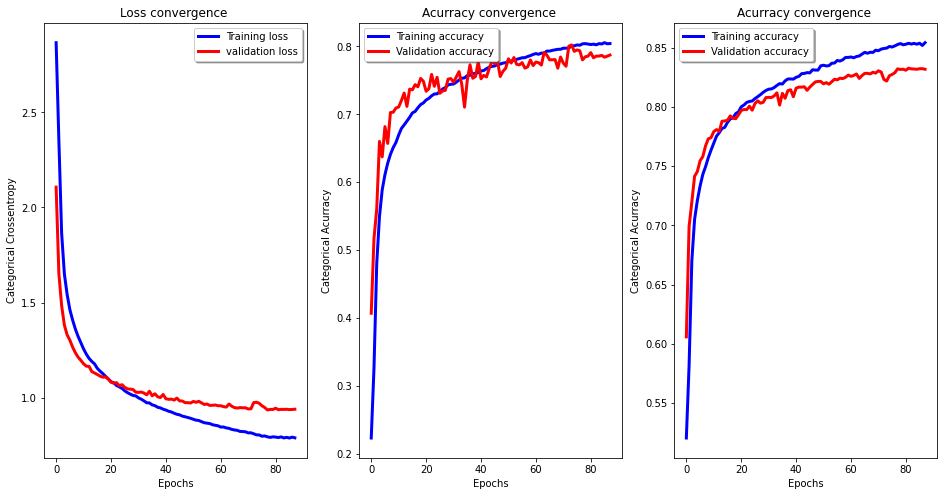

<Figure size 432x288 with 0 Axes>

In [16]:
history = CNN1D.train(model, train_loader, test_loader)
del model

['loss', 'freq_output_categorical_accuracy', 'task_output_categorical_accuracy']
loss 0
freq_output_categorical_accuracy 1
task_output_categorical_accuracy 2


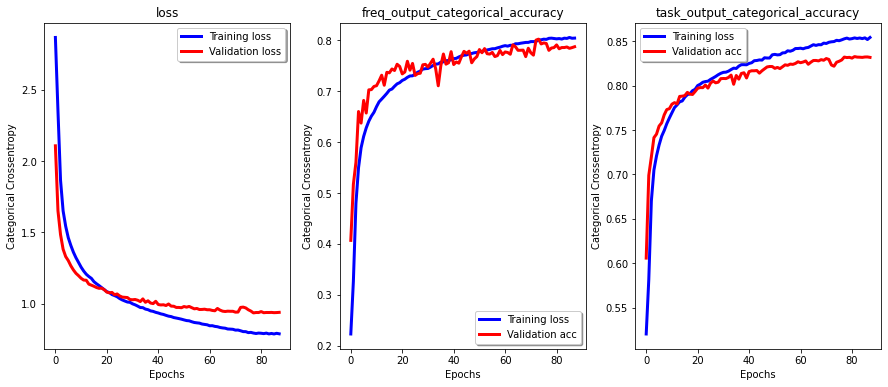

In [119]:
keys=['loss','freq_output_categorical_accuracy','task_output_categorical_accuracy']
utils.plot_history_keys(history,keys, None)

<a name="5"></a>
# Evaluate best model

In [ ]:
if not use_class_weights:
    model = tf.keras.models.load_model(model_name)
else:
    model = tf.keras.models.load_model(model_name, custom_objects={'loss': {'freq_output': weighted_categorical_crossentropy(class_weights_freq),  
                                                                        'task_output': 'categorical_crossentropy'}})

<a name="5-1"></a>
## Peformance on Val Data 

In [ ]:
train_performance=model.evaluate(train_loader)
val_performance=model.evaluate(val_loader)
test_performance=model.evaluate(test_loader)

y_test, y_test_task, y_pred, y_pred_task = utils.generate_data_multihead(val_loader, model)
gesture_list =  ['0', '5.45', '6.67', '8.57', '12']
utils.plot_confusion_matrix(y_test, y_pred, gesture_list, model_name)
utils.plot_confusion_matrix(y_test_task, y_pred_task, ['non_ep', 'ep'], model_name)

<a name="5-2"></a>
## Peformance on Test Data 

2296/2296 [==============================] - 17s 7ms/step - loss: 0.9539 - freq_output_loss: 0.5808 - task_output_loss: 0.3731 - freq_output_categorical_accuracy: 0.7716 - task_output_categorical_accuracy: 0.8281


100%|██████████| 459/459 [00:40<00:00, 11.20it/s]


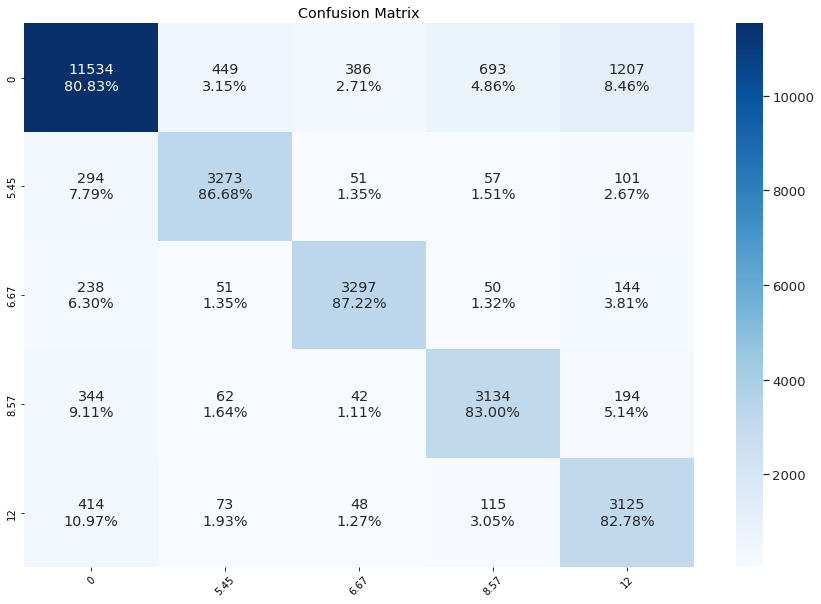

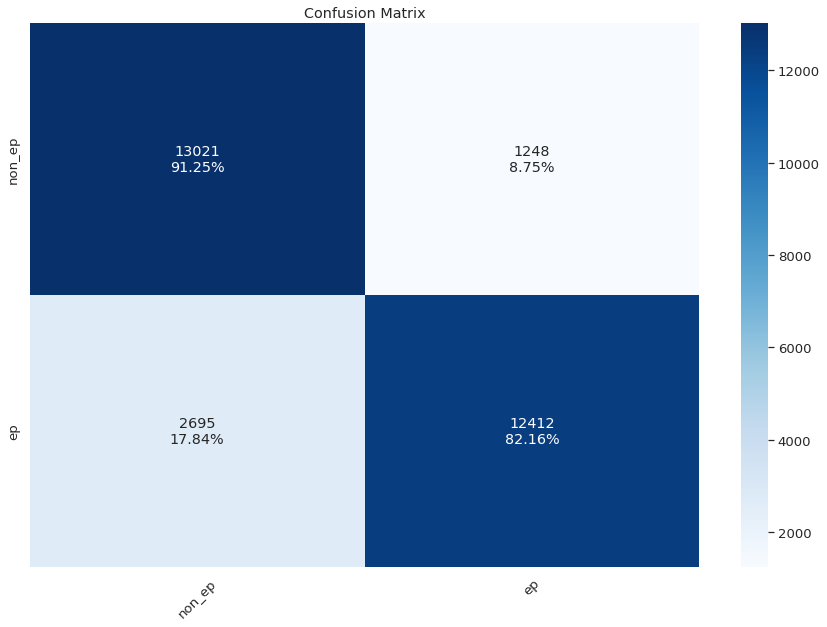

100%|██████████| 2296/2296 [03:17<00:00, 11.60it/s]


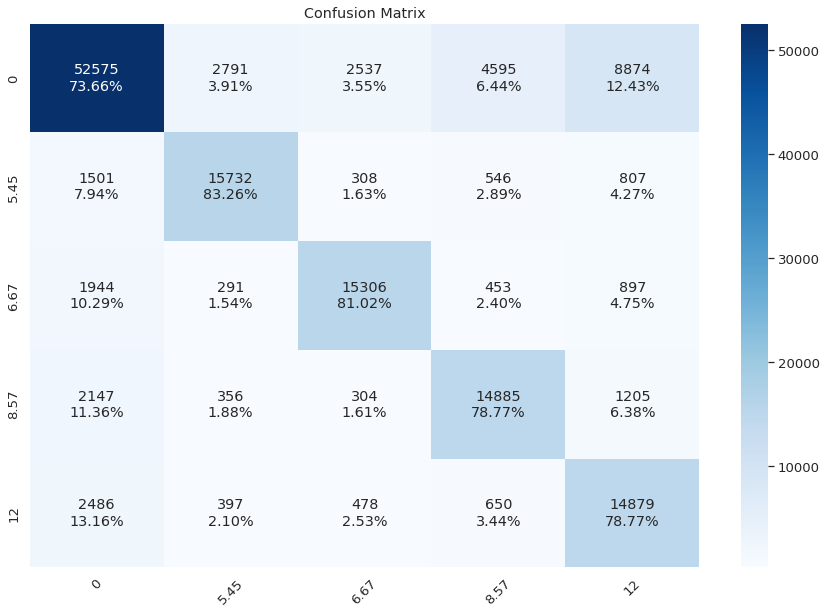

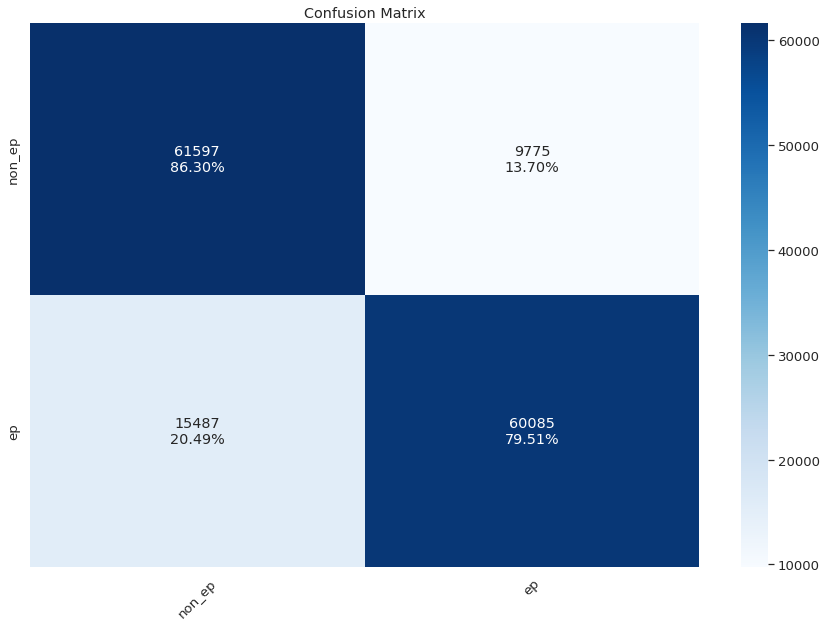

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn

[0.9538758397102356, 0.5808258056640625, 0.3730500042438507, 0.7715660333633423, 0.8280841708183289]
              precision    recall  f1-score   support

           0       0.87      0.74      0.80     71372
        5.45       0.80      0.83      0.82     18894
        6.67       0.81      0.81      0.81     18891
        8.57       0.70      0.79      0.74     18897
          12       0.56      0.79      0.65     18890

    accuracy                           0.77    146944
   macro avg       0.75      0.79      0.76    146944
weighted avg       0.79      0.77      0.78    146944

Accuracy Score : 0.7715660387630662
Precision Score : 0.7483589549844538
Recall Score : 0.7909724779004902
F1-Score : 0.7641769723449154
              precision    recall  f1-score   support

      non_ep       0.80      0.86      0.83     71372
          ep       0.86      0.80      0.83     75572

    accuracy                           0.83    146944
   macro avg       0.83      0.83      0.83    146944
w

In [18]:

y_test, y_test_task, y_pred, y_pred_task = utils.generate_data_multihead(test_loader, model)
gesture_list =  ['0', '5.45', '6.67', '8.57', '12']
plot_confusion_matrix(y_test, y_pred, gesture_list, model_name)
plot_confusion_matrix(y_test_task, y_pred_task, ['non_SSVEP', 'SSVEP'], model_name)

test_precision=skm.precision_score(y_test, y_pred, pos_label='positive', average='macro')
test_recall=skm.recall_score(y_test, y_pred, pos_label='positive',average='macro')
test_f1_score=skm.f1_score(y_test, y_pred,average='macro')

test_precision_task=skm.precision_score(y_test_task, y_pred_task, pos_label='positive', average='macro')
test_recall_task=skm.recall_score(y_test_task, y_pred_task, pos_label='positive',average='macro')
test_f1_score_task=skm.f1_score(y_test_task, y_pred_task,average='macro')

print(test_performance)
print(skm.classification_report(y_test,y_pred,target_names=[str(x) for x in gesture_list]))
print("Accuracy Score :", skm.accuracy_score(y_test,y_pred))
print("Precision Score :",test_precision)
print("Recall Score :",test_recall)
print("F1-Score :",test_f1_score)

print(skm.classification_report(y_test_task,y_pred_task,target_names=[str(x) for x in ['non_SSVEP', 'SSVEP']]))
print("Accuracy Score :", skm.accuracy_score(y_test_task,y_pred_task))
print("Precision Score :",test_precision_task)
print("Recall Score :",test_recall_task)
print("F1-Score :",test_f1_score_task)

<a name="6"></a>
## Save the model in .H5 file

In [33]:
model.save(model_name+f'/{params["model_name"]}.h5')

# mlflow

In [19]:
# #!/usr/bin/env python
# # coding: utf-8

# import h5py
# import sys
# import mlflow
# import json

# def log_into_mlflow_Conv2D(experiment, params_file, factor, D, trainable_count, non_trainable_count, learning_rate, opt, 
#                            test_performance, test_precision_freq, test_recall_freq, test_f1_score_freq, rep,train_performance, val_performance,
#                           test_precision_task, test_recall_task, test_f1_score_task):
#     with mlflow.start_run(experiment_id=experiment.experiment_id):
#          # train model
#         # file loads paramms 
#         f = open(params_file)
#         params = json.load(f)

        
#         mlflow.log_param('dataset_path', params['dataset_path'])
#         mlflow.log_param('h5_file_name_train', params['h5_file_name_train'])
#         mlflow.log_param('h5_file_name_test', params['h5_file_name_test'])
#         mlflow.log_param('preprocessing', params['preprocessing'])

#         #dataset params 
#         mlflow.log_param('extracted_frequencies', params['extracted_frequencies'])
#         mlflow.log_param('features_type', params['features_type'])
#         mlflow.log_param('num_eeg_channels', params['num_channels'])
#         mlflow.log_param('num_class', params['num_classes'])
#         mlflow.log_param('samples', params['num_samples'])
#         mlflow.log_param('window_size', params['window_size'])

#         # model params 
#         mlflow.log_param('model_name', params['model_name'])
#         mlflow.log_param('epochs', params['epochs'])
#         mlflow.log_param('batch_size', params['batchsize'])
#         mlflow.log_param('output_function', params['output_function'])

        
        
#         mlflow.log_param('trainable_count', trainable_count)
#         mlflow.log_param('non_trainable_count', non_trainable_count)

#         mlflow.log_param('factor', factor)
#         mlflow.log_param('D', D)

        
#         mlflow.log_param('learning_rate', learning_rate)
#         mlflow.log_param('optimizer', opt)

        
#         #test metrics
#         mlflow.log_metric('train_accuracy_freq', train_performance[3])#history.history['categorical_accuracy'][-1])
#         mlflow.log_metric('train_accuracy_task', train_performance[4])#history.history['categorical_accuracy'][-1])
        
#         mlflow.log_metric('val_accuracy_freq', val_performance[3])#history.history['val_categorical_accuracy'][-1])
#         mlflow.log_metric('val_accuracy_task', val_performance[4])#history.history['val_categorical_accuracy'][-1])

#         mlflow.log_metric('test_accuracy_freq', test_performance[3])
#         mlflow.log_metric('test_accuracy_task', test_performance[4])
        
#         mlflow.log_metric('test_precision_freq', test_precision_freq)
#         mlflow.log_metric('test_recall_freq', test_recall_freq)
#         mlflow.log_metric('test_f1_score_freq', test_f1_score_freq)
        
#         mlflow.log_metric('test_precision_task', test_precision_task)
#         mlflow.log_metric('test_recall_task', test_recall_task)
#         mlflow.log_metric('test_f1_score_task', test_f1_score_task)

#         mlflow.log_metric('Repetition', rep)


In [20]:
# mlflow.set_experiment("EEG_SSVEP_MI_spectogram2d_conv2d_GAP_1656_NormMinMax2_multitask_allsub_normAxis3_weights")
# experiment = mlflow.get_experiment_by_name("EEG_SSVEP_MI_spectogram2d_conv2d_GAP_1656_NormMinMax2_multitask_allsub_normAxis3_weights")

# experiment

In [21]:

# log_into_mlflow_Conv2D(experiment, params_file, factors[nc], Ds[nd], trainable_count, non_trainable_count, lr_log[opt_ind], opt_log[opt_ind], test_performance, test_precision, test_recall, test_f1_score, rs, train_performance, val_performance, test_precision_task, test_recall_task, test_f1_score_task)